# Inspect whether the cluster runs were successful when using prior samples accepted by the classifier

### Previous best NSF with 30 million simulation budget: 10.75% NaNs

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
import numpy as np
from copy import deepcopy
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from stg_energy.common import col, svg, plot_pdf, samples_nd, get_labels_8pt, reorder_stats
from stg_energy.fig2_inference.viz import get_summ_stat_name, get_summ_stat_name_text, get_synapse_name, get_summ_stat_name_asterisk

In [4]:
PANEL_A = '../svg/panel_supp_compare_maf_a.svg'
PANEL_B = '../svg/panel_supp_compare_maf_b.svg'

In [5]:
path = "../../../results/simulation_data_Tube_MLslurm_cluster/01_simulate_11deg"
x_prior = pd.read_pickle(path + "/data/valid_simulation_outputs.pkl")
x_prior_np = x_prior.to_numpy()

x_prior_np = reorder_stats(x_prior_np)

stats_mean = np.mean(x_prior_np, axis=0)
stats_std = np.std(x_prior_np, axis=0)

In [6]:
path = '../../../results/simulation_data_Tube_MLslurm_cluster/simulate_11deg_R3_predictives_at_11deg/data/all_simulation_outputs.pkl'
posterior_predictives = pd.read_pickle(path)
posterior_predictives_np = posterior_predictives.to_numpy()

In [7]:
posterior_predictives_np = reorder_stats(posterior_predictives_np)

In [8]:
posterior_predictives_np.shape

(1020000, 34)

In [9]:
good_or_not = np.invert(np.any(np.isnan(posterior_predictives_np), axis=1))

In [10]:
good_percentage = np.sum(good_or_not) / posterior_predictives_np.shape[0] * 100
print("Overall percentage of NaNs", 100.-good_percentage, "%")

Overall percentage of NaNs 14.935784313725492 %


In [11]:
xo = np.load("../../../results/experimental_data/xo_11deg.npy")
observation = reorder_stats(xo)[0]

In [12]:
ss_norm = (np.asarray(posterior_predictives_np[:,:15]) - stats_mean[:15]) / stats_std[:15]
norm_gt = (observation[:15] - stats_mean[:15]) / stats_std[:15]

### Better visualization

In [13]:
names = []
for num in range(15):
    names.append(get_summ_stat_name_text(num))

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


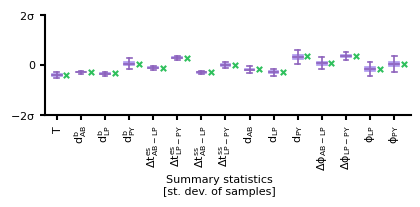

In [14]:
import seaborn as sns
import pandas as pd

with mpl.rc_context(fname='../../../.matplotlibrc'):
    fig, ax = plt.subplots(1,1, figsize=(3.5*1.35, 1.3))
    plt.scatter(np.arange(15)+0.4, norm_gt, marker='x', s=15.0, color=col['GT'])
    df = pd.DataFrame(ss_norm)

    box = sns.boxplot(data=df, width=0.4, fliersize=.0, linewidth=1.2) # , color='#0570b0'
    for i, patch in enumerate(box.artists):
        r, g, b, a = patch.get_facecolor() # r, g, b, a = patch.get_facecolor()
        patch.set_facecolor(col['CONSISTENT2']) # patch.set_facecolor((r, g, b, .6))
        patch.set_edgecolor(col['CONSISTENT2'])
        for j in range(i*6,i*6+6):
            line = ax.lines[j]
            line.set_color(col['CONSISTENT1'])
            line.set_mfc(col['CONSISTENT1'])
            line.set_mec(col['CONSISTENT1'])

    ax.set_ylim([-2,2])
    ax.set_xlim([-0.5,14.7])
    ax.set_xticklabels(names, rotation='vertical')
    ax.set_yticks([-2, 0, 2])
    ax.set_yticklabels(['$\mathdefault{-2}\sigma$', '0', '2$\sigma$'])
    ax.text(0.33,  -0.68, 'Summary statistics', transform=ax.transAxes)
    ax.text(0.322, -0.80, '[st. dev. of samples]', transform=ax.transAxes)
    #plt.savefig('../results/energy/classifier/figs/summstats.png', dpi=300, bbox_inches='tight')
    plt.show()

### Load posterior predictives from delfi with MAF

In [15]:
stats_maf = np.load('../../../results/11deg_post_pred/delfi_maf_post_pred.npz')['all_ss']

In [16]:
stats_maf[:, 7] = stats_maf[:, 7] - stats_maf[:, 6]  # Because we had previously used the delay from AB/PD to PY and now use the delay from LP to PY.

In [17]:
good_s = []
for s in stats_maf:
    if np.invert(np.any(np.isnan(s))):
        good_s.append(s)
good_s = np.asarray(good_s)
print('number of good samples', len(good_s))
print('fraction of bad samples', (len(stats_maf) - len(good_s)) / len(stats_maf) * 100, '%')

number of good samples 396
fraction of bad samples 20.8 %


# Compare to big MAF from big paper

In [18]:
norm_stats_maf = (np.asarray(good_s[:,:15]) - stats_mean[:15]) / stats_std[:15]

In [19]:
norm_stats_maf.shape

(396, 15)

In [20]:
ss_norm.shape

(1020000, 15)

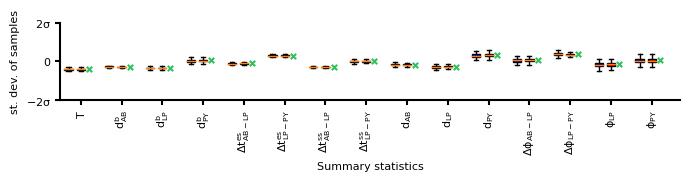

In [21]:
import seaborn as sns
import pandas as pd

with mpl.rc_context(fname='../../../.matplotlibrc'):
    fig, ax = plt.subplots(1,1, figsize=(8., 1.))
    ax.scatter(np.arange(15)+0.2, norm_gt, marker='x', s=15.0, color=col['GT'])

    box1 = ax.boxplot(ss_norm[good_or_not], positions=np.arange(15), widths=0.2, patch_artist=True, showfliers=False)
    box2 = ax.boxplot(norm_stats_maf, positions=np.arange(15)-0.3, widths=0.2, patch_artist=True, showfliers=False) # , color='#0570b0'

    colors = ['r']*15
    for patch, color in zip(box1['boxes'], colors):
        patch.set_facecolor(color)
        
    colors = ['b']*15
    for patch, color in zip(box2['boxes'], colors):
        patch.set_facecolor(color)

    ax.set_ylim([-2,2])
    ax.set_xlim([-0.5,14.7])
    ax.set_xticks(np.arange(15))
    ax.set_xticklabels(names, rotation='vertical')
    ax.set_yticks([-2, 0, 2])
    ax.set_yticklabels(['$\mathdefault{-2}\sigma$', '0', '2$\sigma$'])
    ax.set_xlabel('Summary statistics')
    ax.set_ylabel('st. dev. of samples')
    #plt.savefig('../results/energy/classifier/figs/fig1.png', dpi=300, bbox_inches='tight')
    plt.show()

### Make histogramm

In [22]:
# differences
sd_sbi = (norm_gt - ss_norm[good_or_not])**2
sd_delfi = (norm_gt - norm_stats_maf)**2

In [23]:
summed_square_diff_sbi = np.median(sd_sbi, axis=0)
summed_square_diff_delfi = np.median(sd_delfi, axis=0)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


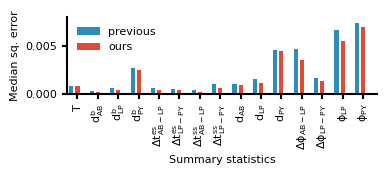

In [24]:
with mpl.rc_context(fname='../../../.matplotlibrc'):
    fig, ax = plt.subplots(1, 1, figsize=(4.0, 1.))
    ax.bar(np.arange(15)-0.3, summed_square_diff_delfi, width=0.2, color='#2b8cbe', label='previous')
    ax.bar(np.arange(15), summed_square_diff_sbi, width=0.2, color='#e34a33', label='ours')
    ax.set_ylim([0, 0.008])
    ax.set_xticks(np.arange(15))
    ax.set_xticklabels(names, rotation='vertical')
    ax.set_xlim([-0.5,14.7])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.legend()

    ax.set_ylabel('Median sq. error')
    ax.set_xlabel('Summary statistics')

    plt.savefig(PANEL_A, facecolor='None', transparent=True)
    plt.show()

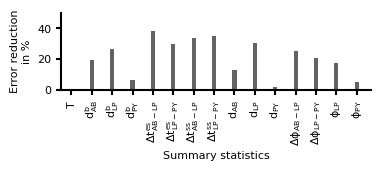

In [25]:
with mpl.rc_context(fname='../../../.matplotlibrc'):
    fig, ax = plt.subplots(1, 1, figsize=(4.0, 1.))
    ax.bar(np.arange(15), (summed_square_diff_delfi - summed_square_diff_sbi) / summed_square_diff_delfi * 100, width=0.2, color='#636363')
    ax.set_ylim([0, 50])
    ax.set_xticks(np.arange(15))
    ax.set_xticklabels(names, rotation='vertical')
    ax.set_xlim([-0.5, 14.7])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.axhline(1.0, linestyle='--', c='grey')

    ax.set_ylabel('Error reduction\nin %')
    ax.set_xlabel('Summary statistics')

    plt.savefig(PANEL_B, facecolor='None', transparent=True)
    plt.show()

### Assemble figure

In [26]:
import time
import IPython.display as IPd

def svg(img):
    IPd.display(IPd.HTML('<img src="{}" / >'.format(img, time.time())))

In [27]:
from svgutils.compose import *

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise
factor_svg=5.5

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
kwargs_consistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_text8pt = {'size': '7.7pt', 'font': 'Arial'}

sizefactor = 1.0

f = Figure("20.3cm", "4.3cm",

    Panel(
          SVG(PANEL_A).scale(svg_scale),
          Text("a", -1*factor_svg, 0*factor_svg, **kwargs_text),
    ).move(2.7*factor_svg, 2*factor_svg),

    Panel(
          SVG(PANEL_B).scale(svg_scale),
          Text("b",-1*factor_svg, -0.6*factor_svg, **kwargs_text),
    ).move(70.1*factor_svg, 2.6*factor_svg),

)

!mkdir -p fig
f.save("../fig/fig2_supp2.svg")
svg('../fig/fig2_supp2.svg')